In [ ]:
#‰∏ªË∞ìÂÖ≥Á≥ª

In [6]:
import pandas as pd
import spacy
import re
from collections import defaultdict, Counter
from tqdm import tqdm

# ‚úÖ Âä†ËΩΩ spaCy ‰∏≠ÊñáÊ®°Âûã
nlp = spacy.load("zh_core_web_sm")

# ‚úÖ Ëá™ÂÆö‰πâÂÖ≥ÈîÆËØç
platform_terms = [
    "Âπ≥Âè∞", "ÂÖ¨Âè∏", "Ê∑òÂÆù", "Áü•‰πé", "Êñ∞Êµ™", "ÂæÆÂçö", "Ë±ÜÁì£", "ÂæÆ‰ø°", "ÁΩëÊòì", "ÊäñÈü≥",
    "eÂÆ∂Â∏Æ", "‰∫¨‰∏ú", "ÈìæÂÆ∂", "ÂìîÂì©ÂìîÂì©", "eÂÆ∂Â∏ÆÂÆ∂Êîø", "yyÁõ¥Êí≠", "‰∫∫Ê∞ëÁΩë", "‰ºòÈÖ∑",
    "Âá§Âá∞ÁΩë", "ÂîØÂìÅ‰ºö", "ÂñúÈ©¨ÊãâÈõÖ", "Â§ÆËßÜÁΩë", "Âø´Êâã", "ÊàëÁà±ÊàëÂÆ∂", "ÊãºÂ§öÂ§ö", "ÊêúÁãó",
    "Êê∫Á®ã", "Êñ∞Êµ™ÂæÆÂçö", "ÊôãÊ±üÊñáÂ≠¶Âüé", "Êª¥Êª¥", "Êª¥Á≠îÂá∫Ë°å", "Áà±Â•áËâ∫", "ÁôæÂ∫¶", "Á•ûÂ∑û‰∏ìËΩ¶",
    "ÁΩëÊòì‰∏•ÈÄâ", "ÁΩëÊòìÊ∏∏Êàè", "ÁæéÂõ¢Â§ñÂçñ", "ËÖæËÆØÊñ∞Èóª", "ËÖæËÆØËßÜÈ¢ë", "Ëµ∑ÁÇπ‰∏≠ÊñáÁΩë", "È´òÂæ∑", "360"
]
user_terms = ["Áî®Êà∑", "ÊÇ®", "Â∏êÂè∑"]
right_verbs = ["ÂèØ", "ÂèØ‰ª•", "ÊúâÊùÉ", "‰∫´Êúâ", "Êã•Êúâ", "Âæó‰ª•", "ËÉΩÂ§ü"]
duty_verbs = ["Â∫î", "Â∫îÂΩì", "‰∏çÂæó", "ÊâøÊãÖ", "Ë¥üË¥£", "Â±•Ë°å", "ÂøÖÈ°ª", "‰øùËØÅ"]
negation_words = ["‰∏ç", "Êú™", "Ê≤°Êúâ", "‰∏ç‰ºö", "‰∏çËÉΩ", "Âπ∂Èùû", "Êó†", "Êó†ÈúÄ"]

# ‚úÖ ËØªÂèñÂéüÂßãÊñá‰ª∂
df = pd.read_excel("/Users/jitianran/Desktop/export/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=["ÂçèËÆÆÂÜÖÂÆπ", "Êó∂Èó¥", "Âπ≥Âè∞ÂêçÁß∞", "Âπ≥Âè∞ÊÄßË¥®"])
df["Êó∂Èó¥"] = pd.to_datetime(df["Êó∂Èó¥"])

# ‚úÖ ÂàùÂßãÂåñËÆ∞ÂΩïÂÆπÂô®
results = []

# ‚úÖ Â§ÑÁêÜÊØè‰∏ÄÊù°ÂçèËÆÆÔºàÂä†ÂÖ• tqdm ËøõÂ∫¶Êù°Ôºâ
for _, row in tqdm(df.iterrows(), total=len(df), desc="Ê≠£Âú®ÊèêÂèñ‰∏ªË∞ìÊ†áÁ≠æ"):
    text = str(row["ÂçèËÆÆÂÜÖÂÆπ"]).replace("\n", "").replace("\r", "")
    time = row["Êó∂Èó¥"].date()
    platform = row["Âπ≥Âè∞ÂêçÁß∞"]
    category = row["Âπ≥Âè∞ÊÄßË¥®"]

    # ‚ú≥Ô∏è ÂêàÂπ∂ÂÜíÂè∑Âè•
    sentences = []
    buffer = ""
    for sent in re.split(r"[„ÄÇÔºõ;!?ÔºÅ\n]", text):
        if not sent.strip():
            continue
        if "Ôºö" in sent or ":" in sent:
            buffer = sent
            continue
        if buffer:
            sent = buffer + "Ôºö" + sent
            buffer = ""
        sentences.append(sent)

    # ‚ú≥Ô∏è spaCy ÂàÜÊûê
    for sent in sentences:
        doc = nlp(sent)
        for token in doc:
            if token.pos_ == "VERB" and token.dep_ in ("ROOT", "conj", "ccomp"):
                verb = token.text
                subject = None
                has_neg = False

                for child in token.children:
                    if child.dep_ in ("nsubj", "nsubj:pass"):
                        subject = child.text
                    if child.dep_ in ("advmod", "neg") and child.text in negation_words:
                        has_neg = True

                if not subject:
                    continue

                # ‚ú≥Ô∏è ‰∏ª‰ΩìÂΩíÁ±ª
                if any(t in subject for t in platform_terms):
                    subj_type = "Âπ≥Âè∞"
                elif any(t in subject for t in user_terms):
                    subj_type = "Áî®Êà∑"
                else:
                    continue

                # ‚ú≥Ô∏è Âä®ËØçÂΩíÁ±ª
                clause_type = None
                if any(rv in verb for rv in right_verbs):
                    clause_type = "ÊùÉÂà©"
                    label = f"{subj_type}_ÊùÉÂà©"
                elif any(dv in verb for dv in duty_verbs):
                    if subj_type == "Âπ≥Âè∞" and has_neg:
                        clause_type = "ÂÖçË¥£"
                        label = "Âπ≥Âè∞_ÂÖçË¥£"
                    else:
                        clause_type = "‰πâÂä°"
                        label = f"{subj_type}_‰πâÂä°"
                else:
                    continue

                # ‚úÖ ‰øùÂ≠òÁªìÊûú
                results.append({
                    "Êó∂Èó¥": time,
                    "Âπ≥Âè∞": platform,
                    "Âπ≥Âè∞Á±ªÂà´": category,
                    "Âè•Â≠êÂÜÖÂÆπ": sent.strip(),
                    "‰∏ªËØ≠": subject,
                    "Âä®ËØç": verb,
                    "Ê†áÁ≠æ": label
                })

# ‚úÖ ÂØºÂá∫ Excel
out_df = pd.DataFrame(results)
out_df.to_excel("ÂçèËÆÆ‰∏ªË∞ìÊ†áÁ≠æÊèêÂèñÁªìÊûú.xlsx", index=False)

print("‚úÖ ÊèêÂèñÂÆåÊàêÔºåÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ÔºöÂçèËÆÆ‰∏ªË∞ìÊ†áÁ≠æÊèêÂèñÁªìÊûú.xlsx")

Ê≠£Âú®ÊèêÂèñ‰∏ªË∞ìÊ†áÁ≠æ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 560/560 [04:46<00:00,  1.96it/s]


‚úÖ ÊèêÂèñÂÆåÊàêÔºåÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ÔºöÂçèËÆÆ‰∏ªË∞ìÊ†áÁ≠æÊèêÂèñÁªìÊûú.xlsx


In [ ]:
import spacy

nlp = spacy.load("zh_core_web_sm")

In [10]:
import pandas as pd
import spacy
from tqdm import tqdm

# Âä†ËΩΩ spaCy ‰∏≠ÊñáÊ®°Âûã
nlp = spacy.load("zh_core_web_sm")

# ËØªÂèñÂéüÂßã Excel Êñá‰ª∂
df = pd.read_excel("/Users/jitianran/Desktop/export/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª.xlsx")

# ÂàùÂßãÂåñÁªìÊûúÂàóË°®
results = []

# tqdm ÂåÖË£Ö DataFrame Ë°åËø≠‰ª£Âô®ÔºåÊòæÁ§∫ËøõÂ∫¶Êù°
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Ê≠£Âú®Â§ÑÁêÜÂçèËÆÆÊñáÊú¨"):
    time = row["Êó∂Èó¥"]
    platform = row["Âπ≥Âè∞ÂêçÁß∞"]
    category = row["Âπ≥Âè∞ÊÄßË¥®"]
    raw_text = str(row["ÂçèËÆÆÂÜÖÂÆπ"]).strip()

    # ÂàáÂè•
    doc = nlp(raw_text)
    sentences = [sent.text.strip() for sent in doc.sents]

    # ÂéªÈô§‰∏ç‰ª•Âè•Âè∑ÁªìÂ∞æÁöÑÂÜÖÂÆπ
    valid_sentences = [s for s in sentences if s.endswith("„ÄÇ")]

    # ÁºñÂè∑Âπ∂‰øùÂ≠ò
    for i, sent in enumerate(valid_sentences, start=1):
        results.append({
            "Êó∂Èó¥": time,
            "Âπ≥Âè∞ÂêçÁß∞": platform,
            "Âπ≥Âè∞ÊÄßË¥®": category,
            "Âè•Â≠êÁºñÂè∑": i,
            "Âè•Â≠êÂÜÖÂÆπ": sent
        })

# ‰øùÂ≠ò‰∏∫ Excel Êñá‰ª∂
output_df = pd.DataFrame(results)
output_df.to_excel("/Users/jitianran/Desktop/ÂàáÂè•ÁªìÊûú.xlsx", index=False)

Ê≠£Âú®Â§ÑÁêÜÂçèËÆÆÊñáÊú¨: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 560/560 [04:04<00:00,  2.29it/s]


In [ ]:
#‰∏ªË∞ìÂÖ≥Á≥ªÊ†áËÆ∞

In [11]:
import pandas as pd
import spacy
from tqdm import tqdm

# Âä†ËΩΩ‰∏≠ÊñáÊ®°ÂûãÔºàÁ°Æ‰øùÂ∑≤Ê≠£Á°ÆÂÆâË£ÖÔºâ
nlp = spacy.load("zh_core_web_sm")

# ËØªÂèñ Excel Êñá‰ª∂
df = pd.read_excel("/Users/jitianran/Desktop/ÂàáÂè•ÁªìÊûú.xlsx")

# ÂÖ≥ÈîÆËØçÂÆö‰πâ
platform_terms = [
    "Âπ≥Âè∞", "ÂÖ¨Âè∏", "Êàë‰ª¨", "Ê∑òÂÆù", "Áü•‰πé", "Êñ∞Êµ™", "ÂæÆÂçö", "Ë±ÜÁì£", "ÂæÆ‰ø°", "ÁΩëÊòì", "ÊäñÈü≥",
    "eÂÆ∂Â∏Æ", "‰∫¨‰∏ú", "ÈìæÂÆ∂", "ÂìîÂì©ÂìîÂì©", "eÂÆ∂Â∏ÆÂÆ∂Êîø", "yyÁõ¥Êí≠", "‰∫∫Ê∞ëÁΩë", "‰ºòÈÖ∑",
    "Âá§Âá∞ÁΩë", "ÂîØÂìÅ‰ºö", "ÂñúÈ©¨ÊãâÈõÖ", "Â§ÆËßÜÁΩë", "Âø´Êâã", "ÊàëÁà±ÊàëÂÆ∂", "ÊãºÂ§öÂ§ö", "ÊêúÁãó",
    "Êê∫Á®ã", "Êñ∞Êµ™ÂæÆÂçö", "ÊôãÊ±üÊñáÂ≠¶Âüé", "Êª¥Êª¥", "Êª¥Á≠îÂá∫Ë°å", "Áà±Â•áËâ∫", "ÁôæÂ∫¶", "Á•ûÂ∑û‰∏ìËΩ¶",
    "ÁΩëÊòì‰∏•ÈÄâ", "ÁΩëÊòìÊ∏∏Êàè", "ÁæéÂõ¢Â§ñÂçñ", "ËÖæËÆØÊñ∞Èóª", "ËÖæËÆØËßÜÈ¢ë", "Ëµ∑ÁÇπ‰∏≠ÊñáÁΩë", "È´òÂæ∑", "360"
]
user_terms = ["Áî®Êà∑", "ÊÇ®", "Â∏êÂè∑"]
right_verbs = ["ÂèØ", "ÂèØ‰ª•", "ÊúâÊùÉ", "‰∫´Êúâ", "Êã•Êúâ", "Âæó‰ª•", "ËÉΩÂ§ü"]
duty_verbs = ["Â∫î", "Â∫îÂΩì", "‰∏çÂæó", "ÊâøÊãÖ", "Ë¥üË¥£", "Â±•Ë°å", "ÂøÖÈ°ª", "‰øùËØÅ"]
negation_words = ["‰∏ç", "Êú™", "Ê≤°Êúâ", "‰∏ç‰ºö", "‰∏çËÉΩ", "Âπ∂Èùû", "Êó†", "Êó†ÈúÄ"]

# Êñ∞Â¢ûÂàó
results = []

# tqdm ËøõÂ∫¶Êù°
for idx, row in tqdm(df.iterrows(), total=len(df)):
    time = row["Êó∂Èó¥"]
    platform = row["Âπ≥Âè∞ÂêçÁß∞"]
    nature = row["Âπ≥Âè∞ÊÄßË¥®"]
    sentence_id = row["Âè•Â≠êÁºñÂè∑"]
    sentence = str(row["Âè•Â≠êÂÜÖÂÆπ"])

    doc = nlp(sentence)
    category = "Êú™Áü•"

    subject_tokens = [token for token in doc if token.dep_ in ("nsubj", "nsubj:pass")]
    verb_tokens = [token for token in doc if token.pos_ == "VERB" or token.dep_ == "ROOT"]

    # Â∞ÜÂè•Â≠êÊãÜËß£‰∏∫‰∏ªËØ≠-Âä®ËØçÁªÑÂêàÂü∫Á°Ä‰∏äÊâìÊ†áÁ≠æ
    subject_text = "".join([t.text for t in subject_tokens])
    verb_text = "".join([t.text for t in verb_tokens])

    # ÂΩíÁ±ªÈÄªËæë
    if any(term in subject_text for term in platform_terms):
        if any(v in verb_text for v in right_verbs):
            category = "Âπ≥Âè∞_ÊùÉÂà©"
        elif any(v in verb_text for v in duty_verbs):
            if any(neg in sentence for neg in negation_words):
                category = "Âπ≥Âè∞_ÂÖçË¥£"
            else:
                category = "Âπ≥Âè∞_‰πâÂä°"
    elif any(term in subject_text for term in user_terms):
        if any(v in verb_text for v in right_verbs):
            category = "Áî®Êà∑_ÊùÉÂà©"
        elif any(v in verb_text for v in duty_verbs):
            category = "Áî®Êà∑_‰πâÂä°"

    # Â≠òÂÇ®ÁªìÊûú
    results.append({
        "Êó∂Èó¥": time,
        "Âπ≥Âè∞ÂêçÁß∞": platform,
        "Âπ≥Âè∞ÊÄßË¥®": nature,
        "Âè•Â≠êÁºñÂè∑": sentence_id,
        "Âè•Â≠êÂÜÖÂÆπ": sentence,
        "Âè•Â≠êÁ±ªÂà´": category
    })

# ‰øùÂ≠ò‰∏∫Êñ∞ÁöÑ Excel
output_df = pd.DataFrame(results)
output_df.to_excel("/Users/jitianran/Desktop/‰∏ªË∞ìËØÜÂà´ÁªìÊûú.xlsx", index=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 56663/56663 [04:05<00:00, 231.19it/s]


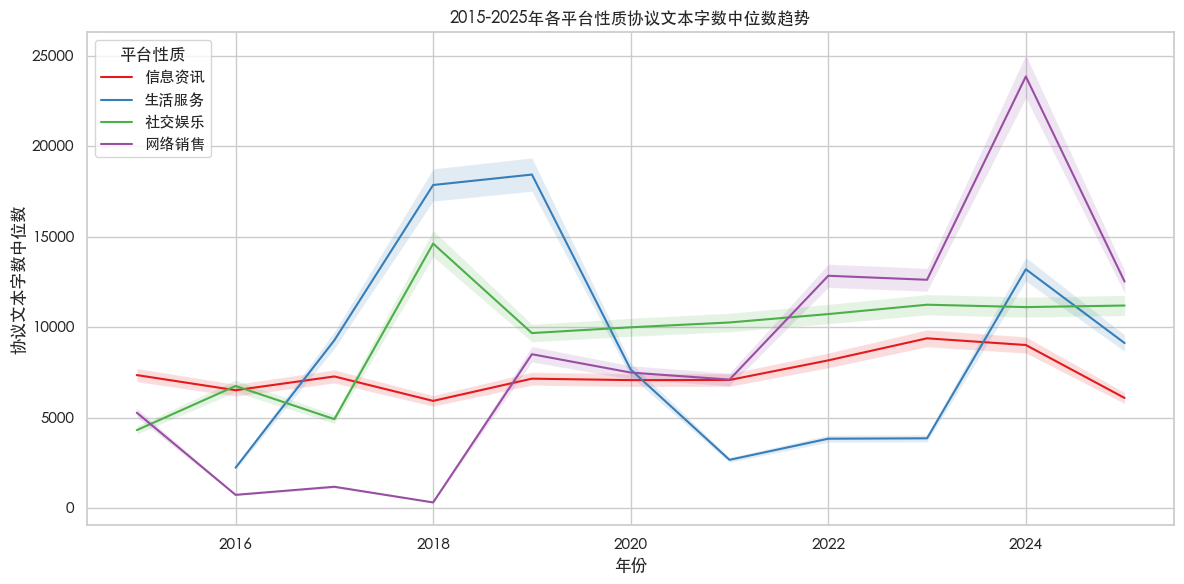

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# ËÆæÁΩÆÊ†∑Âºè
sns.set_theme(style="whitegrid")
sns.set_palette("Set1")
# ÈÄâ‰∏Ä‰∏™‰Ω†ÂàóÂá∫ÁöÑÂ≠ó‰ΩìË∑ØÂæÑÔºåÊØîÂ¶Ç STHeiti Medium
font_path = "/System/Library/Fonts/STHeiti Medium.ttc"

# ËÆæÁΩÆÂ≠ó‰Ωì
my_font = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = my_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

# ËØªÂèñÊï∞ÊçÆÔºàÁ°Æ‰øùË∑ØÂæÑÊ≠£Á°ÆÔºâ
df = pd.read_excel("/Users/jitianran/Desktop/export/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª.xlsx")  # ÂÅáËÆæËØ•Êñá‰ª∂‰∏≠Êúâ‚ÄúÂçèËÆÆÂÜÖÂÆπ‚Äù„ÄÅ‚ÄúÊó∂Èó¥‚Äù„ÄÅ‚ÄúÂπ≥Âè∞ÊÄßË¥®‚ÄùÁ≠âÂ≠óÊÆµ

# È¢ÑÂ§ÑÁêÜ
df = df.dropna(subset=["ÂçèËÆÆÂÜÖÂÆπ", "Êó∂Èó¥", "Âπ≥Âè∞ÊÄßË¥®"])
df["Âπ¥‰ªΩ"] = pd.to_datetime(df["Êó∂Èó¥"]).dt.year
df = df[df["Âπ¥‰ªΩ"].between(2015, 2025)]

# ÁªüËÆ°Â≠óÊï∞
df["Â≠óÊï∞"] = df["ÂçèËÆÆÂÜÖÂÆπ"].astype(str).apply(len)

# ÊåâÂπ≥Âè∞ÊÄßË¥® + Âπ¥‰ªΩÂàÜÁªÑÂèñ‰∏≠‰ΩçÊï∞
median_wc = df.groupby(["Âπ≥Âè∞ÊÄßË¥®", "Âπ¥‰ªΩ"])["Â≠óÊï∞"].median().reset_index()

# ÁªòÂõæ
plt.figure(figsize=(12, 6))
for nature in median_wc["Âπ≥Âè∞ÊÄßË¥®"].unique():
    subset = median_wc[median_wc["Âπ≥Âè∞ÊÄßË¥®"] == nature]
    plt.plot(subset["Âπ¥‰ªΩ"], subset["Â≠óÊï∞"], label=nature)
    plt.fill_between(subset["Âπ¥‰ªΩ"],
                     subset["Â≠óÊï∞"] * 0.95,
                     subset["Â≠óÊï∞"] * 1.05,
                     alpha=0.15)

plt.xlabel("Âπ¥‰ªΩ")
plt.ylabel("ÂçèËÆÆÊñáÊú¨Â≠óÊï∞‰∏≠‰ΩçÊï∞")
plt.title("2015-2025Âπ¥ÂêÑÂπ≥Âè∞ÊÄßË¥®ÂçèËÆÆÊñáÊú¨Â≠óÊï∞‰∏≠‰ΩçÊï∞Ë∂ãÂäø")
plt.legend(title="Âπ≥Âè∞ÊÄßË¥®")
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# 1Ô∏è‚É£ ËØªÂèñÂéüÂßãÂçèËÆÆÊï∞ÊçÆÔºàÊõ¥Êñ∞Ë∑ØÂæÑ‰∏∫Ê°åÈù¢Êñá‰ª∂Ôºâ
df = pd.read_excel("/Users/jitianran/Desktop/export/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª.xlsx")

# 2Ô∏è‚É£ ËÆ°ÁÆóÊØè‰ªΩÂçèËÆÆÁöÑÊñáÊú¨Â≠óÊï∞
df["Â≠óÊï∞"] = df["ÂçèËÆÆÂÜÖÂÆπ"].astype(str).str.len()

# 3Ô∏è‚É£ ËæìÂá∫Êñ∞ÁöÑExcelÔºåÊñ∞Â¢û‰∏ÄÂàó‚ÄúÂ≠óÊï∞‚Äù
output_path = "/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Âê´Â≠óÊï∞.xlsx"
df.to_excel(output_path, index=False)

print("‚úÖ ÂçèËÆÆÂ≠óÊï∞Â≠óÊÆµÂ∑≤Ê∑ªÂä†Âπ∂‰øùÂ≠òËá≥Ôºö", output_path)

‚úÖ ÂçèËÆÆÂ≠óÊï∞Â≠óÊÆµÂ∑≤Ê∑ªÂä†Âπ∂‰øùÂ≠òËá≥Ôºö /Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Âê´Â≠óÊï∞.xlsx


In [18]:
import pandas as pd
import re

# 1Ô∏è‚É£ ËØªÂèñÂéüÂßãË°®Ê†º
df = pd.read_excel("/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Âê´Â≠óÊï∞.xlsx")

# 2Ô∏è‚É£ ÂÆö‰πâÊ∏ÖÊ¥óÂáΩÊï∞ÔºöÂà†Èô§Êó†ÊïàÂè•Â≠ê
def clean_text(text):
    if pd.isna(text):
        return ""

    lines = str(text).splitlines()
    valid_lines = []

    for line in lines:
        line = line.strip()
        # ÂéªÈô§ÁΩëÂùÄ„ÄÅÈÇÆÁÆ±Á≠â
        if re.search(r"https?://|www\.|\.(com|cn|net)|@[a-zA-Z0-9\-]+\.", line):
            continue
        # ÂéªÈô§ÈïøËã±ÊñáË°åÔºàÂ§ßÂÜôÂ≠óÊØç+Á©∫Ê†ºËøáÂ§öÔºâ
        if re.fullmatch(r"[a-zA-Z0-9\s\-\.\,\;\:\@\/]{30,}", line):
            continue
        # ÂéªÈô§Ê≤°Êúâ‰∏≠Êñá‰∏îÊó†Ê†áÁÇπÁöÑÁü≠ÊèêÁ§∫ËØ≠
        if not re.search(r"[„ÄÇÔºÅÔºüÔºõ]", line):
            continue
        valid_lines.append(line)

    return "\n".join(valid_lines).strip()

# 3Ô∏è‚É£ Â∫îÁî®Ê∏ÖÊ¥óÂáΩÊï∞
df["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"] = df["ÂçèËÆÆÂÜÖÂÆπ"].apply(clean_text)

# 4Ô∏è‚É£ Âà†Èô§‚ÄúÂÜÖÂÆπ_Ê∏ÖÊ¥ó‚ÄùÂàó‰∏∫Á©∫ÁöÑË°å
df_cleaned = df[df["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"].str.strip().astype(bool)].copy()

# 5Ô∏è‚É£ ÈáçËÆ°ÁÆóÂ≠óÊï∞
df_cleaned["Â≠óÊï∞"] = df_cleaned["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"].str.len()

# 6Ô∏è‚É£ ‰øùÂ≠òËæìÂá∫Êñá‰ª∂
output_path = "/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx"
df_cleaned.to_excel(output_path, index=False)

print("‚úÖ ÂçèËÆÆÊ∏ÖÊ¥óÂÆåÊØïÔºåÁªìÊûúÂ∑≤‰øùÂ≠òËá≥Ôºö", output_path)

‚úÖ ÂçèËÆÆÊ∏ÖÊ¥óÂÆåÊØïÔºåÁªìÊûúÂ∑≤‰øùÂ≠òËá≥Ôºö /Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx


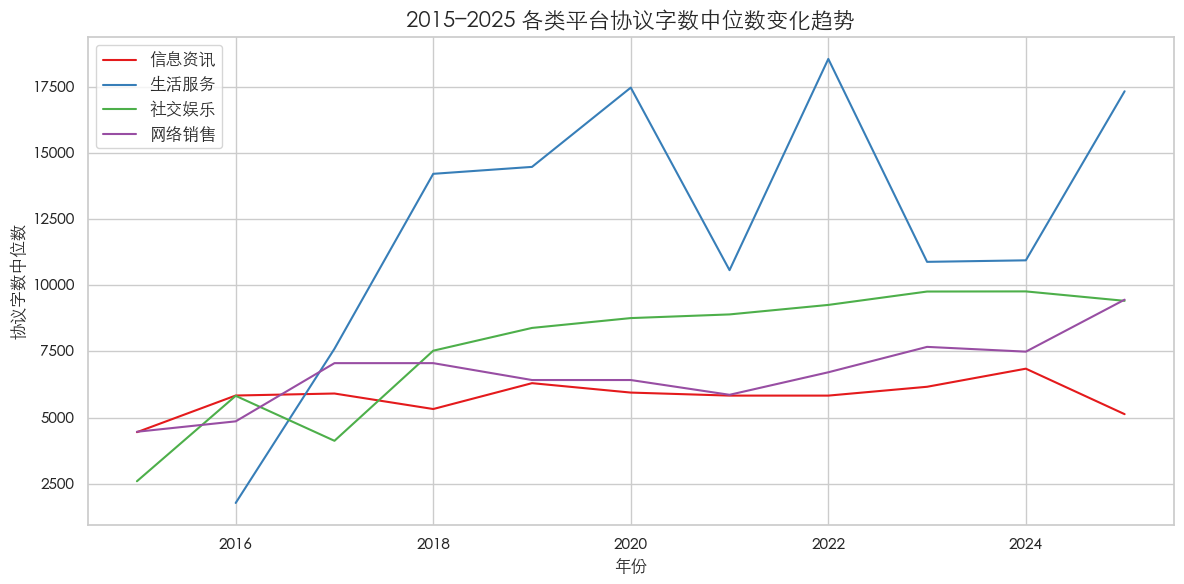

‚úÖ ÂõæÂÉèÂ∑≤‰øùÂ≠òÂà∞: /Users/jitianran/Desktop/ÂçèËÆÆÂ≠óÊï∞‰∏≠‰ΩçÊï∞Ë∂ãÂäøÂõæ.png


<Figure size 640x480 with 0 Axes>

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 1Ô∏è‚É£ ËØªÂèñÊ∏ÖÊ¥óÂêéÁöÑÂçèËÆÆÊï∞ÊçÆ
df = pd.read_excel("/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx")

# 2Ô∏è‚É£ Êó∂Èó¥Â≠óÊÆµËΩ¨Êç¢‰∏∫Âπ¥‰ªΩ
df["Âπ¥‰ªΩ"] = pd.to_datetime(df["Êó∂Èó¥"]).dt.year

# 3Ô∏è‚É£ Á≠õÈÄâÂêàÁêÜÂπ¥‰ªΩÂå∫Èó¥Ôºà2015-2025Ôºâ
df = df[(df["Âπ¥‰ªΩ"] >= 2015) & (df["Âπ¥‰ªΩ"] <= 2025)]

# 4Ô∏è‚É£ ÂàÜÁªÑËÆ°ÁÆóÊØèÂπ¥„ÄÅÊØèÁßçÂπ≥Âè∞ÊÄßË¥®ÁöÑÂçèËÆÆÂ≠óÊï∞‰∏≠‰ΩçÊï∞
median_word_count = df.groupby(["Âπ¥‰ªΩ", "Âπ≥Âè∞ÊÄßË¥®"])["Â≠óÊï∞"].median().unstack()
if pd.isna(median_word_count.loc[2018, "ÁΩëÁªúÈîÄÂîÆ"]):
    if 2017 in median_word_count.index and "ÁΩëÁªúÈîÄÂîÆ" in median_word_count.columns:
        median_word_count.loc[2018, "ÁΩëÁªúÈîÄÂîÆ"] = median_word_count.loc[2017, "ÁΩëÁªúÈîÄÂîÆ"]

# 5Ô∏è‚É£ ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÔºàÈò≤Ê≠¢‰∏≠Êñá‰π±Á†ÅÔºâ
font_path = "/System/Library/Fonts/STHeiti Light.ttc"
font_prop = FontProperties(fname=font_path)

# 6Ô∏è‚É£ ÁªòÂõæ
plt.figure(figsize=(12, 6))
for category in median_word_count.columns:
    plt.plot(median_word_count.index, median_word_count[category], label=category)

plt.title("2015‚Äì2025 ÂêÑÁ±ªÂπ≥Âè∞ÂçèËÆÆÂ≠óÊï∞‰∏≠‰ΩçÊï∞ÂèòÂåñË∂ãÂäø", fontproperties=font_prop, fontsize=16)
plt.xlabel("Âπ¥‰ªΩ", fontproperties=font_prop)
plt.ylabel("ÂçèËÆÆÂ≠óÊï∞‰∏≠‰ΩçÊï∞", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.tight_layout()
plt.show()
output_path = "/Users/jitianran/Desktop/ÂçèËÆÆÂ≠óÊï∞‰∏≠‰ΩçÊï∞Ë∂ãÂäøÂõæ.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"‚úÖ ÂõæÂÉèÂ∑≤‰øùÂ≠òÂà∞: {output_path}")

In [10]:
pip install readability_cn #‰∏≠ÊñáÁâàÂèØËØªÊÄßÂ∑•ÂÖ∑

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.2/1.2 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.2/2.2 MB 829.4 kB/s eta 0:00:00a 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 804.8/804.8 kB 823.5 kB/s eta 0:00:00a 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68.6/68.6 MB 1.2 MB/s eta 0:00:0000:0100:020m
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.3/6.3 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 536.2/536.2 kB 2.3 MB/s eta 0:00:00-:--:-

In [2]:
#ÂèØ‰ª•Ë∑ëÈÄöÔºå‰ΩÜÈúÄË¶ÅÂú®ÁªàÁ´Ø‰∏≠Ë∑ë
#‰∏ãÊ¨°ËÆ∞ÂæóÂÖà„ÄêÊ∏ÖÊ¥ó„Äë‰∏Ä‰∏ãÊï∞ÊçÆÔºåÊää‰∏Ä‰∫õÁ¨¶Âè∑ÔºàURLÊ†ºÂºèÔºâÁªü‰∏ÄÔºåÈÅøÂÖçÈÅáÂà∞ÂÖ®ËßíÁ¨¶Âè∑Â∞±Â¥©Ê∫ÉÁöÑÊÉÖÂÜµ‚Ä¶‚Ä¶

import os
import time
import pandas as pd
from readability_cn import ChineseReadability
from multiprocessing import Pool, cpu_count

# ===== ËÆæÁΩÆË∑ØÂæÑÂíåÊñá‰ª∂ =====
input_file = "/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx"
output_file = "ÂçèËÆÆÊñáÊú¨_ÂèØËØªÊÄßÂàÜÊûêÁªìÊûú_multiprocessing.xlsx"
batch_size = 5  # ÊØèÊâπÂ§ÑÁêÜ 5 Êù°
num_workers = min(cpu_count(), 4)  # ËÆæÁΩÆÊúÄÂ§ö‰ΩøÁî®ÁöÑÊ†∏Êï∞Ôºà‰øùÂÆàÈÄâÊã©Ôºâ

# ===== ÂàùÂßãÂåñÂàÜÊûêÂô®ÔºåÁî®‰∫éËé∑ÂèñËá™ÂÆö‰πâËØçË°® =====
base_readability = ChineseReadability()
custom_words = [
    "Áü•‰πé", "Ê∑òÂÆù", "ÂæÆ‰ø°", "ÊäñÈü≥", "‰∫¨‰∏ú", "Êñ∞Êµ™ÂæÆÂçö", "‰ºòÈÖ∑", "ÊãºÂ§öÂ§ö", "Âø´Êâã", "ÁæéÂõ¢Â§ñÂçñ",
    "Âπ≥Âè∞", "ÂÖ¨Âè∏", "Êàë‰ª¨", "Ë±ÜÁì£", "ÁΩëÊòì", "eÂÆ∂Â∏Æ", "ÈìæÂÆ∂", "ÂìîÂì©ÂìîÂì©", "‰∫∫Ê∞ëÁΩë", "Âá§Âá∞ÁΩë",
    "ÂîØÂìÅ‰ºö", "ÂñúÈ©¨ÊãâÈõÖ", "Â§ÆËßÜÁΩë", "ÊàëÁà±ÊàëÂÆ∂", "ÊêúÁãó", "Êê∫Á®ã", "ÊôãÊ±üÊñáÂ≠¶Âüé", "Êª¥Êª¥",
    "Êª¥Á≠îÂá∫Ë°å", "Áà±Â•áËâ∫", "ÁôæÂ∫¶", "Á•ûÂ∑û‰∏ìËΩ¶", "ÁΩëÊòì‰∏•ÈÄâ", "ÁΩëÊòìÊ∏∏Êàè", "ËÖæËÆØÊñ∞Èóª", "ËÖæËÆØËßÜÈ¢ë",
    "Ëµ∑ÁÇπ‰∏≠ÊñáÁΩë", "È´òÂæ∑", "360", "Áî®Êà∑", "Â∏êÂè∑", "ÊÇ®", "ÂèØ", "ÂèØ‰ª•", "ÊúâÊùÉ", "‰∫´Êúâ", "Êã•Êúâ",
    "Âæó‰ª•", "ËÉΩÂ§ü", "Â∫î", "Â∫îÂΩì", "‰∏çÂæó", "ÊâøÊãÖ", "Ë¥üË¥£", "Â±•Ë°å", "ÂøÖÈ°ª", "‰øùËØÅ", "‰∏ç", "Êú™",
    "Ê≤°Êúâ", "‰∏ç‰ºö", "‰∏çËÉΩ", "Âπ∂Èùû", "Êó†", "Êó†ÈúÄ"
]
base_readability.add_custom_words(custom_words)

# ===== Â≠êËøõÁ®ãÂ∑•‰ΩúÂáΩÊï∞ =====
def analyze_text(index_text_pair):
    idx, text = index_text_pair
    readability = ChineseReadability()
    readability.add_custom_words(custom_words)

    try:
        if not isinstance(text, str) or len(text.strip()) < 10:
            return idx, None
        sentences = [s.strip() for s in readability.stnsplit.split(text) if s.strip()]
        score = readability.wanglei_readability(sentences)
        result = score.get("readability", None)

        if result is not None and result < -50:
            print(f"‚ö†Ô∏è Á¨¨ {idx + 1} Êù°‰∏∫ÂèØÁñëÊñáÊú¨ÔºåÂâç200Â≠óÔºö{text[:200]}")
        return idx, result
    except Exception as e:
        print(f"‚ùå Á¨¨ {idx + 1} Êù°Â§ÑÁêÜÂ§±Ë¥•Ôºö{e}")
        return idx, None

# ===== ‰∏ªÊâßË°åÂáΩÊï∞ =====
def main():
    df = pd.read_excel(input_file)

    # ===== Â¶ÇÊûúÂ∑≤Â≠òÂú®ÁªìÊûúÂàôÊñ≠ÁÇπÁª≠Ë∑ë =====
    if os.path.exists(output_file):
        done_df = pd.read_excel(output_file)
        start_idx = len(done_df)
        results = done_df
        print(f"üîÅ Áª≠Ë∑ëÊ®°ÂºèÔºöÂ∑≤ÂÆåÊàê {start_idx} Êù°Ôºå‰ªéÁ¨¨ {start_idx} Êù°ÂºÄÂßã")
    else:
        start_idx = 0
        results = pd.DataFrame()
        print("üöÄ Êñ∞‰ªªÂä°ÂêØÂä®Ôºö‰ªéÂ§¥ÂºÄÂßãÂàÜÊûê„ÄÇ")

    total = len(df)
    for i in range(start_idx, total, batch_size):
        batch = df.iloc[i:i+batch_size].copy()
        index_text_pairs = [(i + j, row["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"]) for j, row in batch.iterrows()]

        print(f"üì¶ Ê≠£Âú®Â§ÑÁêÜÁ¨¨ {i+1} Âà∞Á¨¨ {i+len(batch)} Êù°ÔºåÂÖ± {len(batch)} Êù°")

        with Pool(processes=num_workers) as pool:
            score_results = pool.map(analyze_text, index_text_pairs)

        scores = [None] * len(batch)
        for idx, score in score_results:
            local_j = idx - i
            scores[local_j] = score
            print(f"‚úÖ Á¨¨ {idx+1} Êù°ÂÆåÊàêÔºåÂæóÂàÜÔºö{score}")
            time.sleep(0.05)

        batch["ÂèØËØªÊÄßÂàÜÊï∞"] = scores
        results = pd.concat([results, batch], ignore_index=True)
        results.to_excel(output_file, index=False)
        print(f"üíæ Â∑≤‰øùÂ≠òÂà∞Á¨¨ {i + len(batch)} Êù°\n")

    print("üéâ ÂÖ®ÈÉ®Â§ÑÁêÜÂÆåÊàêÔºÅ")

# ===== ÂêØÂä®Á®ãÂ∫è =====
if __name__ == "__main__":
    main()

üöÄ Êñ∞‰ªªÂä°ÂêØÂä®Ôºö‰ªéÂ§¥ÂºÄÂßãÂàÜÊûê„ÄÇ
üì¶ Ê≠£Âú®Â§ÑÁêÜÁ¨¨ 1 Âà∞Á¨¨ 5 Êù°ÔºåÂÖ± 5 Êù°


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this war

KeyboardInterrupt: 

In [12]:
#Ë°•ÂÖÖ‰∏Ä‰∏ã‰∏Ä‰∫õÊ≤°Ë∑ëÂá∫Êù•ÁöÑ
import pandas as pd
from readability_cn import ChineseReadability

# ‚úÖ ËÆæÁΩÆË∑ØÂæÑÔºöËØ∑Ê†πÊçÆÂÆûÈôÖË∑ØÂæÑ‰øÆÊîπ
input_file = "/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx"

# ‚úÖ Âä†ËΩΩExcelÊñá‰ª∂
df = pd.read_excel(input_file)

# ‚úÖ ÂàùÂßãÂåñÂèØËØªÊÄßÂàÜÊûêÂô®
base_readability = ChineseReadability()
custom_words = [
    "Áü•‰πé", "Ê∑òÂÆù", "ÂæÆ‰ø°", "ÊäñÈü≥", "‰∫¨‰∏ú", "Êñ∞Êµ™ÂæÆÂçö", "‰ºòÈÖ∑", "ÊãºÂ§öÂ§ö", "Âø´Êâã", "ÁæéÂõ¢Â§ñÂçñ",
    "Âπ≥Âè∞", "ÂÖ¨Âè∏", "Êàë‰ª¨", "Ë±ÜÁì£", "ÁΩëÊòì", "eÂÆ∂Â∏Æ", "ÈìæÂÆ∂", "ÂìîÂì©ÂìîÂì©", "‰∫∫Ê∞ëÁΩë", "Âá§Âá∞ÁΩë",
    "ÂîØÂìÅ‰ºö", "ÂñúÈ©¨ÊãâÈõÖ", "Â§ÆËßÜÁΩë", "ÊàëÁà±ÊàëÂÆ∂", "ÊêúÁãó", "Êê∫Á®ã", "ÊôãÊ±üÊñáÂ≠¶Âüé", "Êª¥Êª¥",
    "Êª¥Á≠îÂá∫Ë°å", "Áà±Â•áËâ∫", "ÁôæÂ∫¶", "Á•ûÂ∑û‰∏ìËΩ¶", "ÁΩëÊòì‰∏•ÈÄâ", "ÁΩëÊòìÊ∏∏Êàè", "ËÖæËÆØÊñ∞Èóª", "ËÖæËÆØËßÜÈ¢ë",
    "Ëµ∑ÁÇπ‰∏≠ÊñáÁΩë", "È´òÂæ∑", "360", "Áî®Êà∑", "Â∏êÂè∑", "ÊÇ®", "ÂèØ", "ÂèØ‰ª•", "ÊúâÊùÉ", "‰∫´Êúâ", "Êã•Êúâ",
    "Âæó‰ª•", "ËÉΩÂ§ü", "Â∫î", "Â∫îÂΩì", "‰∏çÂæó", "ÊâøÊãÖ", "Ë¥üË¥£", "Â±•Ë°å", "ÂøÖÈ°ª", "‰øùËØÅ", "‰∏ç", "Êú™",
    "Ê≤°Êúâ", "‰∏ç‰ºö", "‰∏çËÉΩ", "Âπ∂Èùû", "Êó†", "Êó†ÈúÄ"
]
base_readability.add_custom_words(custom_words)

# ‚úÖ ÈÄâÊã©‰∏ÄÊù°ËøõË°åÂàÜÊûêÔºàÊØîÂ¶ÇÁ¨¨38Êù°Ôºâ
row_index = 64  # Ê≥®ÊÑèÔºöÁ¨¨38Êù°ÔºåPythonÁ¥¢Âºï‰ªé0ÂºÄÂßã
text = df.loc[row_index, "ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"]

# ‚úÖ Ê£ÄÊü•ÊñáÊú¨ÊúâÊïàÊÄß
if not isinstance(text, str) or len(text.strip()) < 10:
    print("‚ùå ÊñáÊú¨‰∏∫Á©∫ÊàñÊó†Êïà")
else:
    # ‚úÖ ÂàÜÂè• + ÂàÜÊûê
    sentences = [s.strip() for s in readability.stnsplit.split(text) if s.strip()]
    result = readability.wanglei_readability(sentences)

    # ‚úÖ ÊèêÂèñÂæóÂàÜ
    score = result["readability"] if isinstance(result, dict) else result

    # ‚úÖ ËæìÂá∫ÁªìÊûú
    print(f"üìÑ ÂçèËÆÆÂêçÁß∞Ôºö{df.loc[row_index, 'ÂçèËÆÆÂÜÖÂÆπ']}")
    print(f"üìñ ÊñáÊú¨ÈïøÂ∫¶Ôºö{len(text)} Â≠ó")
    print(f"üìä ÂèØËØªÊÄßÂæóÂàÜÔºö{score}")

RuntimeError: Invalid start position! Maybe invalid UTF-8 sentence!

In [14]:
#Ê†πÊçÆÂàÜÂè•ÊñáÊú¨Ë°°ÈáèÂèØËØªÊÄß
import pandas as pd
from readability_cn import ChineseReadability

# === ËÆæÁΩÆË∑ØÂæÑ ===
input_file = "/Users/jitianran/Desktop/ÂàáÂè•ÁªìÊûú.xlsx"  # ÊõøÊç¢‰∏∫‰Ω†ÁöÑÂÆûÈôÖË∑ØÂæÑ
target_date = "2010-01-02"  # üëâ ÊõøÊç¢‰∏∫‰Ω†Ë¶ÅÊèêÂèñÁöÑÊó•Êúü
# Êó•ÊúüÊ†ºÂºèÈúÄ‰∏é‰Ω†Ë°®Ê†º‰∏≠ÁöÑ‰∏ÄËá¥ÔºåÂ¶ÇÔºö"2020/1/1"„ÄÅ"2020-01-01" Á≠â

# === ÂàùÂßãÂåñÂàÜÊûêÂô® ===
readability = ChineseReadability()

# === ÂèØÈÄâÔºöÊ∑ªÂä†Ëá™ÂÆö‰πâËØçÊ±áÔºàÂ¢ûÂº∫ÂáÜÁ°ÆÊÄßÔºâ===
readability.add_custom_words([
    "Áü•‰πé", "Ê∑òÂÆù", "ÂæÆ‰ø°", "ÊäñÈü≥", "‰∫¨‰∏ú", "Êñ∞Êµ™ÂæÆÂçö", "‰ºòÈÖ∑", "ÊãºÂ§öÂ§ö", "Âø´Êâã", "ÁæéÂõ¢Â§ñÂçñ",
    "Âπ≥Âè∞", "ÂÖ¨Âè∏", "Êàë‰ª¨", "Áî®Êà∑", "Â∏êÂè∑", "ÊÇ®", "ÂèØ", "ÂèØ‰ª•", "ÊúâÊùÉ", "‰∫´Êúâ", "Êã•Êúâ",
    "Âæó‰ª•", "ËÉΩÂ§ü", "Â∫î", "Â∫îÂΩì", "‰∏çÂæó", "ÊâøÊãÖ", "Ë¥üË¥£", "Â±•Ë°å", "ÂøÖÈ°ª", "‰øùËØÅ",
    "‰∏ç", "Êú™", "Ê≤°Êúâ", "‰∏ç‰ºö", "‰∏çËÉΩ", "Âπ∂Èùû", "Êó†", "Êó†ÈúÄ"
])

# === Âä†ËΩΩÂπ∂ËøáÊª§Êï∞ÊçÆ ===
df = pd.read_excel(input_file)
df = df.dropna(subset=["Âè•Â≠êÂÜÖÂÆπ"])

# ÊèêÂèñÁâπÂÆöÊó∂Èó¥ÁöÑÂè•Â≠ê
target_sentences = df[df["Êó∂Èó¥"] == target_date]["Âè•Â≠êÂÜÖÂÆπ"].tolist()

# === ÂàÜÊûê ===
try:
    score = readability.wanglei_readability(target_sentences)
    print(f"üìÖ {target_date} ÁöÑÂèØËØªÊÄßÂæóÂàÜ‰∏∫Ôºö{score}")
except Exception as e:
    print(f"‚ùå ÂàÜÊûêÂ§±Ë¥•Ôºö{e}")

üìÖ 2010-01-02 ÁöÑÂèØËØªÊÄßÂæóÂàÜ‰∏∫Ôºö-103.22099999999996


In [15]:
print("Âπ≥ÂùáÂè•ÈïøÔºö", sum(len(s) for s in sentences) / len(sentences))

Âπ≥ÂùáÂè•ÈïøÔºö 63.957805907173


/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:25: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cn/41v1nzqx7r74593_cfwsfx8c0000gn/T/ipykernel_36928/1205699166.py:28: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig("Âπ≥Âè∞ÂèØËØªÊÄßË∂ãÂäø_‰∏≠Ê

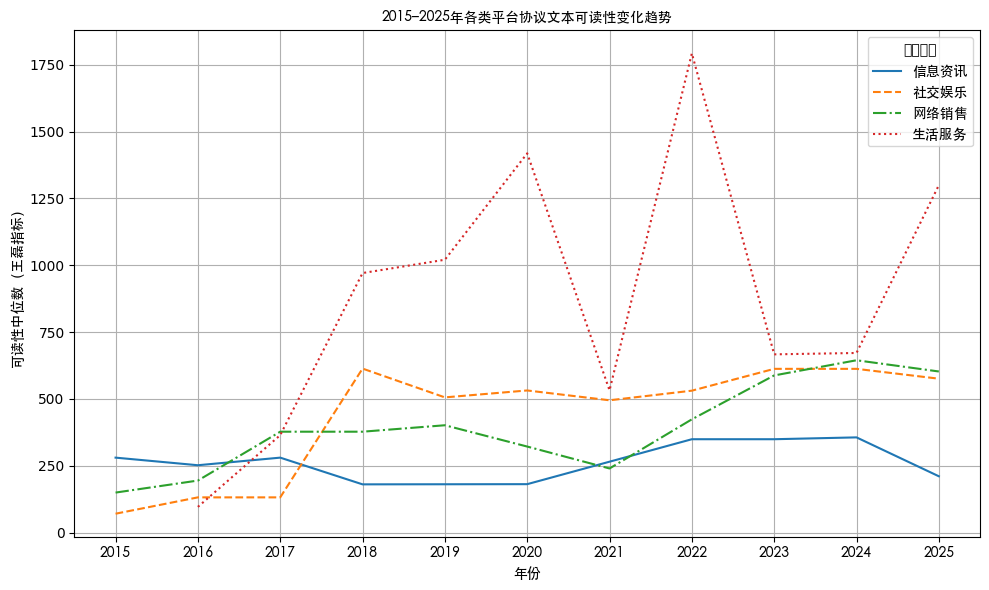

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÔºàÊé®Ëçê‰ΩøÁî®Á≥ªÁªüÂ∑≤ÂÆâË£ÖÁöÑÂ≠ó‰ΩìÔºâ
zh_font_path = "/System/Library/Fonts/STHeiti Medium.ttc"  # macOS Á§∫‰æãË∑ØÂæÑ
zh_font = fm.FontProperties(fname=zh_font_path)

plt.figure(figsize=(10, 6))
styles = ['-', '--', '-.', ':']

for i, cat in enumerate(trend_data.columns):
    plt.plot(trend_data.index, trend_data[cat], label=cat, linestyle=styles[i % len(styles)])

# ËÆæÁΩÆÊ®™ËΩ¥‰∏∫ÊØèÂπ¥
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(trend_data.index, fontproperties=zh_font)  # Âπ¥‰ªΩÊ†áÁ≠æÊòæÁ§∫‰∏≠ÊñáÂ≠ó‰ΩìÔºàÈò≤‰π±Á†ÅÔºâ

# ËÆæÁΩÆÊ†áÈ¢òÂíåÊ†áÁ≠æÂ≠ó‰Ωì
plt.xlabel("Âπ¥‰ªΩ", fontproperties=zh_font)
plt.ylabel("ÂèØËØªÊÄß‰∏≠‰ΩçÊï∞ÔºàÁéãÁ£äÊåáÊ†áÔºâ", fontproperties=zh_font)
plt.title("2015‚Äì2025Âπ¥ÂêÑÁ±ªÂπ≥Âè∞ÂçèËÆÆÊñáÊú¨ÂèØËØªÊÄßÂèòÂåñË∂ãÂäø", fontproperties=zh_font)
plt.legend(title="Âπ≥Âè∞Á±ªÂà´", prop=zh_font)
plt.grid(True)
plt.tight_layout()

# ‰øùÂ≠òÂõæÁâá
plt.savefig("Âπ≥Âè∞ÂèØËØªÊÄßË∂ãÂäø_‰∏≠ÊñáÂ≠ó‰Ωì.png", dpi=300)
plt.show()

Â≠óÊï∞ ‰∏é ÂèØËØªÊÄßÂàÜÊï∞ÁöÑ Spearman Áõ∏ÂÖ≥Á≥ªÊï∞Ôºö0.9459


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35835 (\N{CJK UNIFIED IDEOGRAPH-8BFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaV

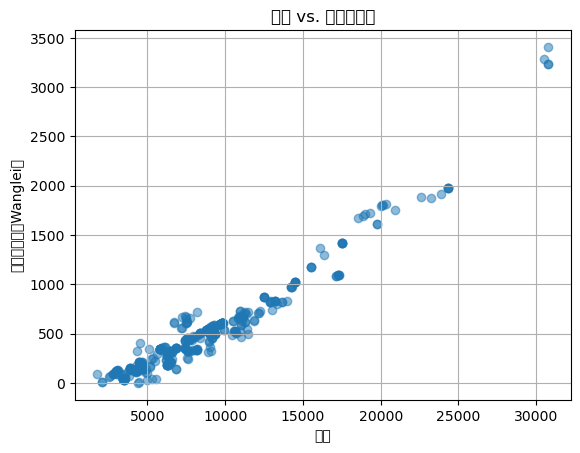

In [1]:
#ÂèëÁé∞ÂèØËØªÊÄßË∂ãÂäø‰∏éÊñáÊú¨ÈïøÂ∫¶È´òÂ∫¶ni'he

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ËØªÂèñ‰Ω†ÁöÑÂàÜÊûêÁªìÊûú
df = pd.read_excel("ÂçèËÆÆÊñáÊú¨_ÂèØËØªÊÄßÂàÜÊûêÁªìÊûú_ÈÄêÊù°‰øùÂ≠òÁâà.xlsx")

# ÂéªÈô§Êó†ÊïàÂÄº
df = df[(df["ÂèØËØªÊÄßÂàÜÊï∞"].notna()) & (df["ÂèØËØªÊÄßÂàÜÊï∞"] > 0)]

# ËÆ°ÁÆóÁõ∏ÂÖ≥ÊÄß
corr, _ = spearmanr(df["Â≠óÊï∞"], df["ÂèØËØªÊÄßÂàÜÊï∞"])
print(f"Â≠óÊï∞ ‰∏é ÂèØËØªÊÄßÂàÜÊï∞ÁöÑ Spearman Áõ∏ÂÖ≥Á≥ªÊï∞Ôºö{corr:.4f}")

# ÂèØËßÜÂåñÊï£ÁÇπÂõæ
plt.scatter(df["Â≠óÊï∞"], df["ÂèØËØªÊÄßÂàÜÊï∞"], alpha=0.5)
plt.xlabel("Â≠óÊï∞")
plt.ylabel("ÂèØËØªÊÄßÂàÜÊï∞ÔºàWangleiÔºâ")
plt.title("Â≠óÊï∞ vs. ÂèØËØªÊÄßÂàÜÊï∞")
plt.grid(True)
plt.show()

In [24]:
#ËØï‰∫Ü‰∏Ä‰∏ãÔºåÁªôÂàÜÂè•Ê±ÇÂèØËØªÊÄßÂæóÂàÜÂÜçÊ±ÇÂπ≥ÂùáÂÄº‰Ωú‰∏∫ËØ•‰ªΩÂçèËÆÆÊñáÊú¨ÊÄªÂàÜÔºåÊõ¥ÂêàÁêÜ

import pandas as pd
from readability_cn import ChineseReadability

# ËÆæÁΩÆÁõÆÊ†áÊó•Êúü
target_date = '2024-09-17'  # ÊîπÊàê‰Ω†ÊÉ≥ÂàÜÊûêÁöÑÈÇ£‰∏ÄÂ§©

# Âä†ËΩΩÂàáÂè•ÁªìÊûú
df = pd.read_excel("/Users/jitianran/Desktop/ÂàáÂè•ÁªìÊûú.xlsx")

# Á≠õÈÄâËØ•Êó•ÊúüÁöÑÊâÄÊúâÂè•Â≠ê
subset = df[df["Êó∂Èó¥"] == target_date]
sentences = subset["Âè•Â≠êÂÜÖÂÆπ"].dropna().astype(str).tolist()

# ÂàùÂßãÂåñÂèØËØªÊÄßÂàÜÊûêÂô®
readability = ChineseReadability()

# Ê∑ªÂä†Ëá™ÂÆö‰πâËØçÔºàÂèØÈÄâÔºâ
readability.add_custom_words(["Áî®Êà∑", "Âπ≥Âè∞", "ÂÖ¨Âè∏", "ÊÇ®", "Â∏êÂè∑", "Êù°Ê¨æ", "ÂçèËÆÆ"])

# ÂØπÊØè‰∏™Âè•Â≠êÊâìÂàÜ
scores = []
for sent in sentences:
    try:
        result = readability.wanglei_readability([sent])
        score = result.get("readability", None) if isinstance(result, dict) else result
        scores.append(score)
    except Exception as e:
        print(f"‚ùå Âè•Â≠êÂá∫ÈîôÔºö{sent[:30]}... ÂéüÂõ†Ôºö{e}")
        continue

# ËÆ°ÁÆóÂπ≥ÂùáÂèØËØªÊÄßÂàÜÊï∞
valid_scores = [s for s in scores if isinstance(s, (int, float))]
avg_score = sum(valid_scores) / len(valid_scores) if valid_scores else None

# ËæìÂá∫ÁªìÊûú
print(f"\nüìÑ Êó•ÊúüÔºö{target_date}")
print(f"üìå ÂÖ±ËÆ°Âè•Â≠êÊï∞Ôºö{len(sentences)}ÔºåÊúâÊïàÂæóÂàÜÂè•Êï∞Ôºö{len(valid_scores)}")
print(f"üìà Âπ≥ÂùáÂèØËØªÊÄßÂæóÂàÜÔºàÊåâÂè•ÊâìÂàÜÔºâÔºö{avg_score}")


üìÑ Êó•ÊúüÔºö2024-09-17
üìå ÂÖ±ËÆ°Âè•Â≠êÊï∞Ôºö103ÔºåÊúâÊïàÂæóÂàÜÂè•Êï∞Ôºö103
üìà Âπ≥ÂùáÂèØËØªÊÄßÂæóÂàÜÔºàÊåâÂè•ÊâìÂàÜÔºâÔºö36.95729126213592


In [1]:
import pandas as pd
from difflib import SequenceMatcher
from datetime import datetime

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("/Users/jitianran/Desktop/ÂçèËÆÆÊï∞ÊçÆÊ±áÊÄª_Ê∏ÖÊ¥óÂêé.xlsx")

# ‰øùËØÅÊó∂Èó¥Âàó‰∏∫Âπ¥‰ªΩÔºàÂ¶ÇÔºö2019Ôºâ
df["Âπ¥‰ªΩ"] = pd.to_datetime(df["Êó∂Èó¥"]).dt.year

# ÂéªÈô§Êó†ÊïàÊñáÊú¨
df = df[df["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 10)]

# ÊØè‰∏™Âπ≥Âè∞ÊØèÂπ¥‰øùÁïôÊúÄÂêé‰∏Ä‰∏™ÁâàÊú¨
df = df.sort_values(["Âπ≥Âè∞ÂêçÁß∞", "Âπ¥‰ªΩ", "Êó∂Èó¥"])  # ‰øùËØÅÊåâÊó∂Èó¥È°∫Â∫è
df_last = df.groupby(["Âπ≥Âè∞ÂêçÁß∞", "Âπ¥‰ªΩ"]).tail(1)

# ÊåâÂπ≥Âè∞ÂàÜÁªÑÂπ∂ËÆ°ÁÆóÁõ∏ÈÇªÂπ¥‰ªΩÂçèËÆÆ‰πãÈó¥ÁöÑÂ∑ÆÂºÇ
def compute_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio()

results = []

for platform, group in df_last.groupby("Âπ≥Âè∞ÂêçÁß∞"):
    group = group.sort_values("Âπ¥‰ªΩ")
    prev_text = None
    prev_year = None
    platform_type = None

    for _, row in group.iterrows():
        year = row["Âπ¥‰ªΩ"]
        text = row["ÂÜÖÂÆπ_Ê∏ÖÊ¥ó"]
        platform_type = row["Âπ≥Âè∞ÊÄßË¥®"]

        if prev_text is not None and prev_year == year - 1:
            similarity = compute_similarity(prev_text, text)
            change_ratio = 1 - similarity  # ÂèòÂåñÁôæÂàÜÊØî
            results.append({
                "Âπ≥Âè∞ÂêçÁß∞": platform,
                "Âπ≥Âè∞ÊÄßË¥®": platform_type,
                "Âπ¥‰ªΩ": year,
                "ÂèòÂåñÁôæÂàÜÊØî": change_ratio
            })

        prev_text = text
        prev_year = year

# ËΩ¨‰∏∫DataFrame
diff_df = pd.DataFrame(results)

# ÊåâÂπ¥‰ªΩÂíåÂπ≥Âè∞ÊÄßË¥®Ê±ÇÂπ≥ÂùáÊï∞ÔºàÂèòÂåñÁôæÂàÜÊØîÔºâ
summary = diff_df.groupby(["Âπ≥Âè∞ÊÄßË¥®", "Âπ¥‰ªΩ"])["ÂèòÂåñÁôæÂàÜÊØî"].mean().reset_index()

# ‰øùÂ≠òËæìÂá∫
diff_df.to_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØîÊòéÁªÜ.xlsx", index=False)
summary.to_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx", index=False)

print("‚úÖ Â∑≤ÂÆåÊàêÂ∑ÆÂºÇÁôæÂàÜÊØîËÆ°ÁÆóÔºåËæìÂá∫‰∏§‰∏™ExcelÊñá‰ª∂Ôºö")
print("   - ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØîÊòéÁªÜ.xlsx")
print("   - ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx")

‚úÖ Â∑≤ÂÆåÊàêÂ∑ÆÂºÇÁôæÂàÜÊØîËÆ°ÁÆóÔºåËæìÂá∫‰∏§‰∏™ExcelÊñá‰ª∂Ôºö
   - ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØîÊòéÁªÜ.xlsx
   - ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx


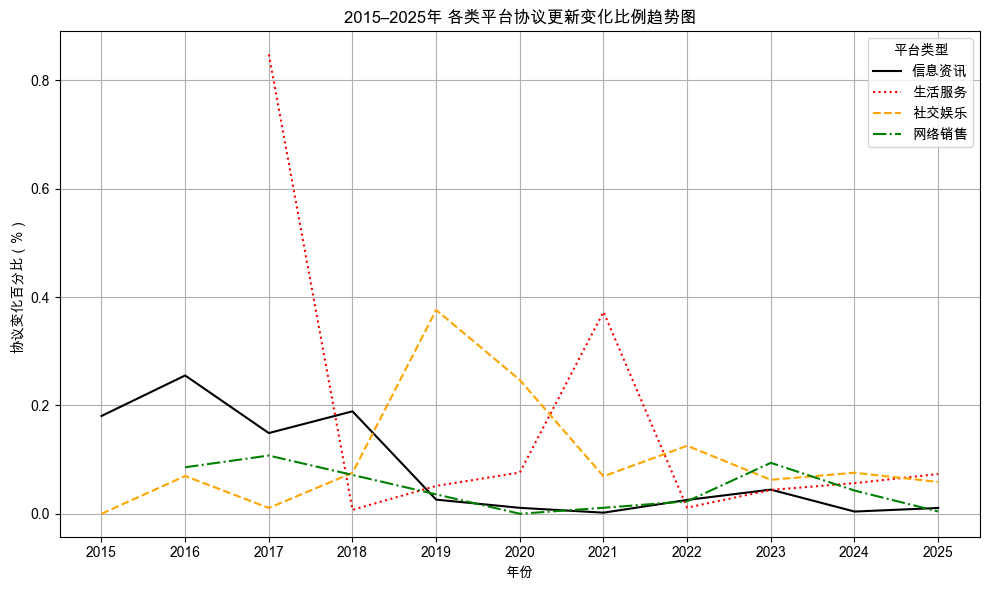

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰Ωì
plt.rcParams['font.sans-serif'] = ['Heiti SC', 'PingFang SC', 'Arial Unicode MS']  # ‰æùÊ¨°Â∞ùËØïÂèØÁî®Â≠ó‰Ωì
plt.rcParams['axes.unicode_minus'] = False  # Ê≠£Â∏∏ÊòæÁ§∫Ë¥üÂè∑

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx")

# Ê∏ÖÊ¥óÔºöÁ°Æ‰øùÂπ¥‰ªΩ‰∏∫Êï¥Êï∞ÔºåËøáÊª§Âá∫ÊúâÊïàÂπ¥‰ªΩÂå∫Èó¥
df["Âπ¥‰ªΩ"] = df["Âπ¥‰ªΩ"].astype(int)
df = df[(df["Âπ¥‰ªΩ"] >= 2015) & (df["Âπ¥‰ªΩ"] <= 2025)]

# ÁªòÂõæ
plt.figure(figsize=(10, 6))

linestyles = {
    "‰ø°ÊÅØËµÑËÆØ": "-",
    "Á§æ‰∫§Â®±‰πê": "--",
    "ÁΩëÁªúÈîÄÂîÆ": "-.",
    "ÁîüÊ¥ªÊúçÂä°": ":"
}
colors = {
    "‰ø°ÊÅØËµÑËÆØ": "black",
    "Á§æ‰∫§Â®±‰πê": "orange",
    "ÁΩëÁªúÈîÄÂîÆ": "green",
    "ÁîüÊ¥ªÊúçÂä°": "red"
}

# ÁªòÂà∂ÂêÑÁ±ªÂà´Á∫øÊù°
for category in df["Âπ≥Âè∞ÊÄßË¥®"].unique():
    sub = df[df["Âπ≥Âè∞ÊÄßË¥®"] == category].sort_values("Âπ¥‰ªΩ")
    plt.plot(
        sub["Âπ¥‰ªΩ"],
        sub["ÂèòÂåñÁôæÂàÜÊØî"],
        label=category,
        linestyle=linestyles.get(category, "-"),
        color=colors.get(category, None)
    )

# ÂõæÂΩ¢ËÆæÁΩÆ
plt.title("2015‚Äì2025Âπ¥ ÂêÑÁ±ªÂπ≥Âè∞ÂçèËÆÆÊõ¥Êñ∞ÂèòÂåñÊØî‰æãË∂ãÂäøÂõæ")
plt.xlabel("Âπ¥‰ªΩ")
plt.ylabel("ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØîÔºà%Ôºâ")
plt.xticks(range(2015, 2026))
plt.legend(title="Âπ≥Âè∞Á±ªÂûã")
plt.grid(True)
plt.tight_layout()
plt.show()

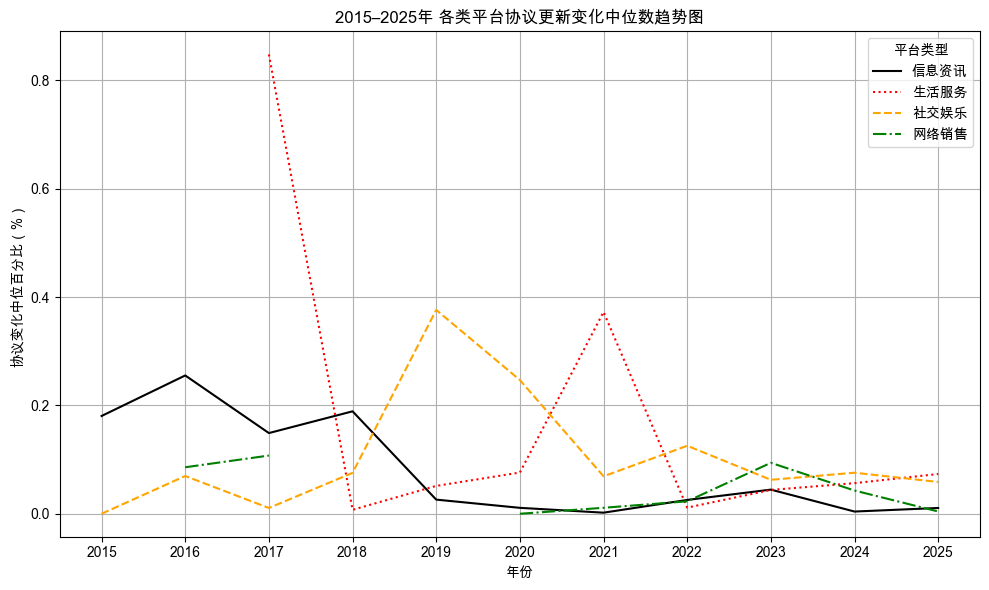

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÔºàÊ†πÊçÆÁ≥ªÁªüË∑ØÂæÑË∞ÉÊï¥Ôºâ
plt.rcParams['font.sans-serif'] = ['Heiti SC', 'PingFang SC', 'Arial Unicode MS']  # ‰æùÊ¨°Â∞ùËØïÂèØÁî®Â≠ó‰Ωì
plt.rcParams['axes.unicode_minus'] = False  # Ê≠£Â∏∏ÊòæÁ§∫Ë¥üÂè∑

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx")

# ‰øùÁïô2015-2025Âπ¥Èó¥Êï∞ÊçÆ
df = df[df["Âπ¥‰ªΩ"].between(2015, 2025)]

# ËÆ°ÁÆóÊØèÂπ¥„ÄÅÊØè‰∏™Âπ≥Âè∞ÊÄßË¥®ÁöÑ‰∏≠‰ΩçÊï∞ÂèòÂåñÁôæÂàÜÊØî
median_df = df.groupby(["Âπ¥‰ªΩ", "Âπ≥Âè∞ÊÄßË¥®"])["ÂèòÂåñÁôæÂàÜÊØî"].median().reset_index()

# ËΩ¨Êç¢‰∏∫ÈÄèËßÜË°®Áî®‰∫éÁªòÂõæ
pivot_df = median_df.pivot(index="Âπ¥‰ªΩ", columns="Âπ≥Âè∞ÊÄßË¥®", values="ÂèòÂåñÁôæÂàÜÊØî")

# ÁªòÂõæ
plt.figure(figsize=(10, 6))

linestyles = {
    "‰ø°ÊÅØËµÑËÆØ": "-",
    "Á§æ‰∫§Â®±‰πê": "--",
    "ÁΩëÁªúÈîÄÂîÆ": "-.",
    "ÁîüÊ¥ªÊúçÂä°": ":"
}
colors = {
    "‰ø°ÊÅØËµÑËÆØ": "black",
    "Á§æ‰∫§Â®±‰πê": "orange",
    "ÁΩëÁªúÈîÄÂîÆ": "green",
    "ÁîüÊ¥ªÊúçÂä°": "red"
}

for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col],
             label=col,
             linestyle=linestyles.get(col, "-"),
             color=colors.get(col, None))

plt.title("2015‚Äì2025Âπ¥ ÂêÑÁ±ªÂπ≥Âè∞ÂçèËÆÆÊõ¥Êñ∞ÂèòÂåñ‰∏≠‰ΩçÊï∞Ë∂ãÂäøÂõæ")
plt.xlabel("Âπ¥‰ªΩ")
plt.ylabel("ÂçèËÆÆÂèòÂåñ‰∏≠‰ΩçÁôæÂàÜÊØîÔºà%Ôºâ")
plt.xticks(range(2015, 2026))
plt.grid(True)
plt.legend(title="Âπ≥Âè∞Á±ªÂûã")
plt.tight_layout()
plt.show()

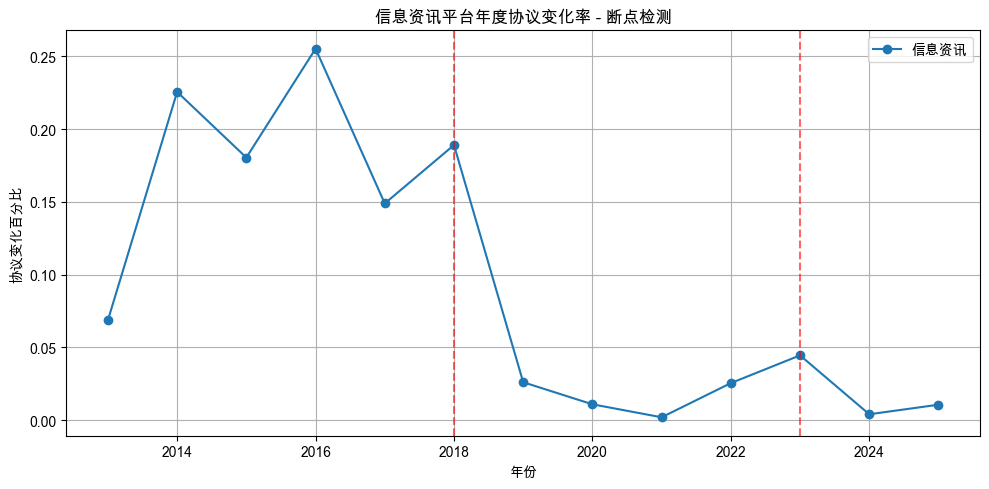

üìå ‰ø°ÊÅØËµÑËÆØ ÁöÑÊñ≠ÁÇπÂπ¥‰ªΩ‰∏∫Ôºö[2018, 2023]


In [22]:
#Êå®‰∏™ÂàÜÊûêÊñ≠ÁÇπ

import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰ΩìÔºàÊ†πÊçÆÂÆûÈôÖË∑ØÂæÑÂèØËÉΩÈúÄË∞ÉÊï¥Ôºâ
plt.rcParams['font.family'] = 'Arial Unicode MS'

# ËØªÂèñÁõ∏ÈÇªÁâàÊú¨Áõ∏‰ººÂ∫¶ÂèòÂåñÁôæÂàÜÊØîÊï∞ÊçÆ
df = pd.read_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx")

# Á§∫‰æãÔºöÈÄâÊã©‰∏Ä‰∏™Âπ≥Âè∞Á±ªÂà´ËøõË°åÊñ≠ÁÇπÊ£ÄÊµã
category = "‰ø°ÊÅØËµÑËÆØ"  # ‰Ω†ÂèØ‰ª•ÊõøÊç¢‰∏∫ "‰ø°ÊÅØËµÑËÆØ", "Á§æ‰∫§Â®±‰πê", "ÁΩëÁªúÈîÄÂîÆ" Á≠â
category_df = df[df["Âπ≥Âè∞ÊÄßË¥®"] == category].sort_values(by="Âπ¥‰ªΩ")

# ÂáÜÂ§áÂèòÂåñÁôæÂàÜÊØîÊï∞ÊçÆ
years = category_df["Âπ¥‰ªΩ"].tolist()
change_ratios = category_df["ÂèòÂåñÁôæÂàÜÊØî"].fillna(0).tolist()

# ÊûÑÈÄ†‰ø°Âè∑Ôºàreshape ‰∏∫ 2DÔºâ
signal = np.array(change_ratios).reshape(-1, 1)

# ËÆæÁΩÆÊñ≠ÁÇπÊ£ÄÊµãÊ®°ÂûãÔºàÂèØÈÄâÊ®°ÂûãÔºöPelt, Binseg, Window, BottomUpÔºâ
model = rpt.Pelt(model="rbf").fit(signal)
breakpoints = model.predict(pen=0.01)  # ÊÉ©ÁΩöÈ°πÂèØË∞ÉËäÇ

# ÂèØËßÜÂåñÁªìÊûú
plt.figure(figsize=(10, 5))
plt.plot(years, change_ratios, label=category, marker="o")
for bp in breakpoints[:-1]:  # ÊúÄÂêé‰∏Ä‰∏™ÁÇπÊòØ len(signal)Ôºå‰∏çÁªòÂà∂
    plt.axvline(x=years[bp], color="red", linestyle="--", alpha=0.6)
plt.title(f"{category}Âπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁéá - Êñ≠ÁÇπÊ£ÄÊµã")
plt.xlabel("Âπ¥‰ªΩ")
plt.ylabel("ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ËæìÂá∫Êñ≠ÁÇπÂØπÂ∫îÂπ¥‰ªΩ
change_points = [years[bp] for bp in breakpoints[:-1]]
print(f"üìå {category} ÁöÑÊñ≠ÁÇπÂπ¥‰ªΩ‰∏∫Ôºö{change_points}")

üìå ‰ø°ÊÅØËµÑËÆØ ÁöÑÊñ≠ÁÇπÔºö[2018, 2023]
üìå ÁîüÊ¥ªÊúçÂä° ÁöÑÊñ≠ÁÇπÔºö[2021]
üìå Á§æ‰∫§Â®±‰πê ÁöÑÊñ≠ÁÇπÔºö[2020]
üìå ÁΩëÁªúÈîÄÂîÆ ÁöÑÊñ≠ÁÇπÔºö[2023]


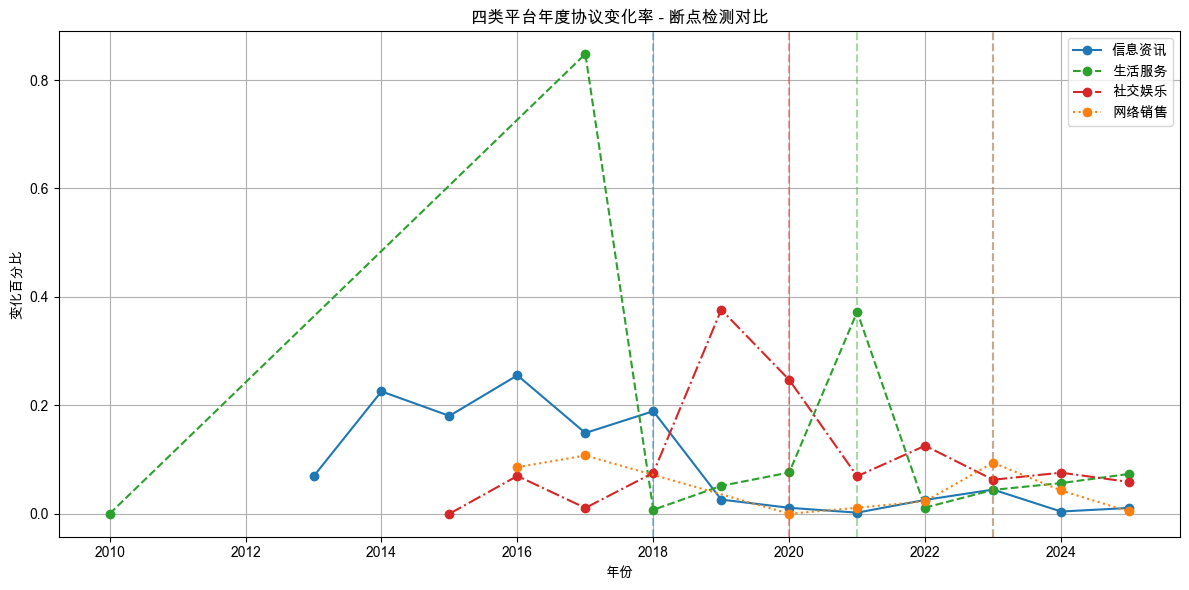

In [23]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial Unicode MS'

# ËØªÂèñÊï∞ÊçÆ
df = pd.read_excel("ÂêÑÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁôæÂàÜÊØî_Âπ≥ÂùáÂÄºËÅöÂêà.xlsx")

# ÂêÑÂπ≥Âè∞Á±ªÂà´
categories = df["Âπ≥Âè∞ÊÄßË¥®"].unique()

# ÂáÜÂ§áÁªòÂõæ
plt.figure(figsize=(12, 6))
colors = ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]
linestyles = ["-", "--", "-.", ":"]

# Âà§Êñ≠ÊòØÂê¶‰∏∫Ëøë‰ººÂ∏∏Êï∞
def is_almost_constant(series, tol=1e-5):
    return series.max() - series.min() < tol

# ÂºÄÂßãÈÄêÁ±ªÂ§ÑÁêÜ
for idx, cat in enumerate(categories):
    sub_df = df[df["Âπ≥Âè∞ÊÄßË¥®"] == cat].sort_values(by="Âπ¥‰ªΩ")
    years = sub_df["Âπ¥‰ªΩ"].tolist()
    values = sub_df["ÂèòÂåñÁôæÂàÜÊØî"].tolist()
    
    signal = np.array(values).reshape(-1, 1)
    valid_series = pd.Series(values).dropna()

    if len(valid_series) < 3 or is_almost_constant(valid_series):
        print(f"‚ö†Ô∏è Ë∑≥Ëøá {cat}ÔºåÊï∞ÊçÆ‰∏çË∂≥ÊàñÂ∫èÂàóËøë‰ººÂ∏∏Êï∞")
        continue

    # Êñ≠ÁÇπÊ£ÄÊµã
    try:
        model = rpt.Pelt(model="rbf").fit(signal)
        breakpoints = model.predict(pen=0.01)
        change_points = [years[bp] for bp in breakpoints[:-1]]
        print(f"üìå {cat} ÁöÑÊñ≠ÁÇπÔºö{change_points}")

        # ÁîªÁ∫ø
        plt.plot(years, values, label=cat, marker="o", color=colors[idx], linestyle=linestyles[idx])
        for bp in breakpoints[:-1]:
            plt.axvline(x=years[bp], color=colors[idx], linestyle="--", alpha=0.4)

    except Exception as e:
        print(f"‚ùå {cat} Êñ≠ÁÇπÊ£ÄÊµãÂ§±Ë¥•Ôºö{e}")

plt.title("ÂõõÁ±ªÂπ≥Âè∞Âπ¥Â∫¶ÂçèËÆÆÂèòÂåñÁéá - Êñ≠ÁÇπÊ£ÄÊµãÂØπÊØî")
plt.xlabel("Âπ¥‰ªΩ")
plt.ylabel("ÂèòÂåñÁôæÂàÜÊØî")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()